In [2]:
import numpy as np

from dataclasses import dataclass
from typing import List, Dict
from copy import copy

from common.function import BaseOptimisationFunction
from common.generator import splitter, batch_generator

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [4]:
def draw_linear(
    x: np.ndarray, 
    y_actual: np.ndarray,
    w_actual: np.ndarray,
    y_predict: np.ndarray = None,
    w_predicted: np.ndarray = None
):
  linear_grid = np.linspace(x.min(), x.max(), 100)
  
  if y_predict is not None:
    plt.scatter(x, y_predict, label="predict")
  
  if w_predicted is not None:
    plt.plot(linear_grid, linear_grid * w_predicted[0] + w_predicted[1], label="predicted linear")
    
  plt.scatter(x, y_actual, label="true")
  plt.plot(linear_grid, linear_grid * w_actual[0] + w_actual[1], label="actual linear")

  plt.title("Dependecies")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()

In [5]:
n_samples = 4096 * 4
n_features = 1
n_targets = 1

In [6]:
bias_actual = 32.
noise = 512

In [7]:
X, Y, coeff_actual = make_regression(
  n_samples=n_samples,
  n_features=n_features,
  n_informative=n_features, 
  n_targets=n_targets,
  coef=True,
  bias=bias_actual,
  noise=noise, random_state=42
)
coeff_actual = [coeff_actual.tolist()] if coeff_actual.shape == () else coeff_actual

Y = Y.reshape((Y.shape[0], 1))

In [8]:
X.shape, Y.shape

((16384, 1), (16384, 1))

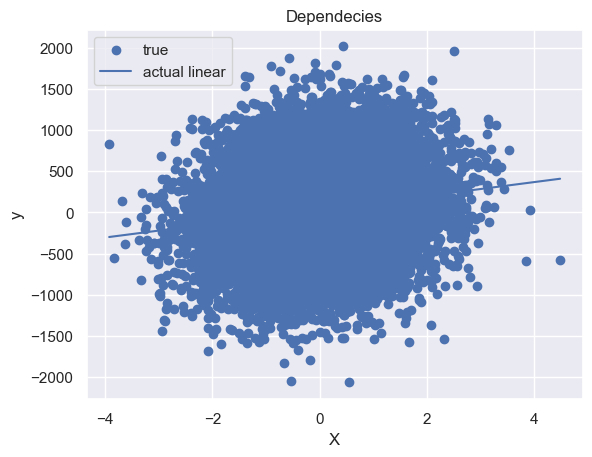

In [9]:
if n_features == 1 and n_targets == 1:
  draw_linear(X, Y, np.array([*coeff_actual, bias_actual]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=42
)

In [11]:
n_clients = 150

In [16]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from common.distributor import UniformDataDistributor, BaseDataDistributor
from optimization.federative.fedavg import FederatedAveraging, BaseFederatedOptimizer

In [18]:
from common.function import MSERidgeLinear, MSELassoLinear

In [22]:
distributor = UniformDataDistributor(
  X=X_train,
  y=y_train,
  n_parts=n_clients
)

In [23]:
from common.pipeline import Pipeline


For parameters: {'clients_fraction': 0.1, 'batch_size': 16, 'epochs': 2, 'rounds': 128, 'eta': 0.001}:
mse : 256275.62073010937
mae : 401.3609148202346
mape : 1.5438130714197824

For parameters: {'clients_fraction': 0.1, 'batch_size': 16, 'epochs': 2, 'rounds': 512, 'eta': 0.001}:
mse : 256355.27419084898
mae : 401.57949332076674
mape : 1.435706551963087


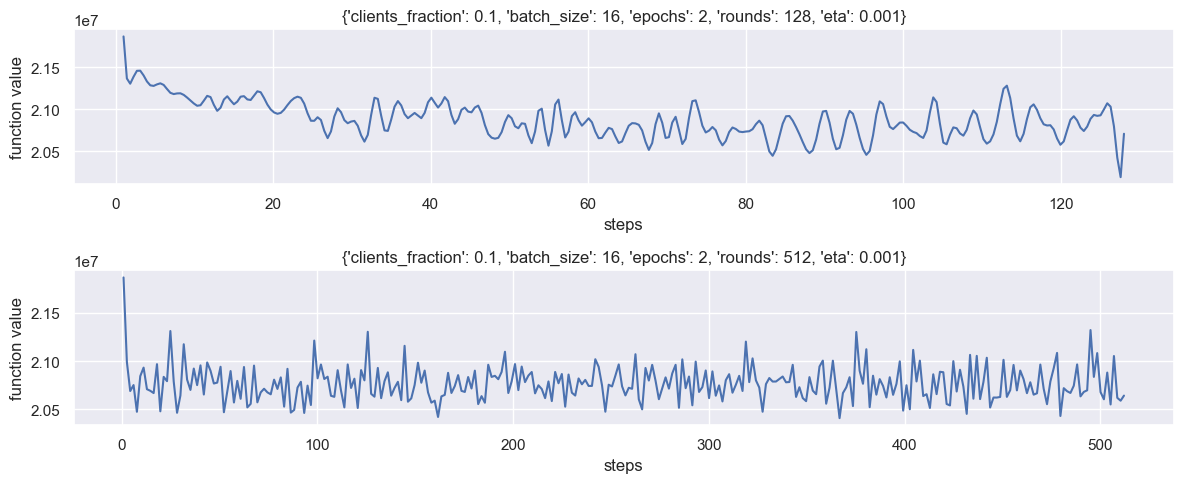

In [24]:
mse = MSERidgeLinear(n_features=n_features)
avg = FederatedAveraging(mse, distributor)

parameters = {
  "clients_fraction": [0.1],
  "batch_size": [16],
  "epochs": [2],
  "rounds": [128, 512],
  "eta": [1e-3],
}
metrics = {
  "mse" : mean_squared_error, 
  "mae" : mean_absolute_error, 
  "mape" : mean_absolute_percentage_error
}

pipeline = Pipeline(
  optimizer=avg,
  parameters=parameters,
  metrics=metrics,
  X_test=X_test,
  y_test=y_test
)

best, best_params = pipeline.run(
  choose_best_by="mae",
  show_history="smooth"
)

In [ ]:
string = "hello"
type(string) is str

True

In [ ]:
best_params

{'clients_fraction': 0.3,
 'batch_size': 16,
 'epochs': 4,
 'rounds': 128,
 'eta': 0.001}

  MSE: 255924.12105934523
  MAE: 401.2552139049265
  MAPE: 1.5093838085327205


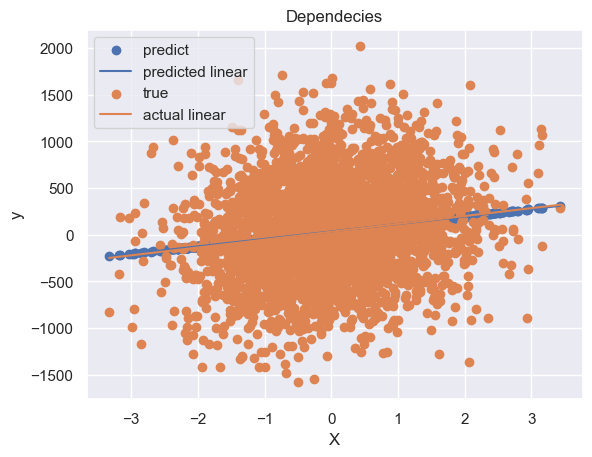

In [ ]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X_test, y_test, np.array([*coeff_actual, bias_actual]),
    best.predict(X_test), best.weights()
  )
print(f"\
  MSE: {mean_squared_error(y_test, best.predict(X_test))}\n\
  MAE: {mean_absolute_error(y_test, best.predict(X_test))}\n\
  MAPE: {mean_absolute_percentage_error(y_test, best.predict(X_test))}\
")

In [ ]:
dict({str({str([1, 2]) : 2}) : 1})

{"{'[1, 2]': 2}": 1}

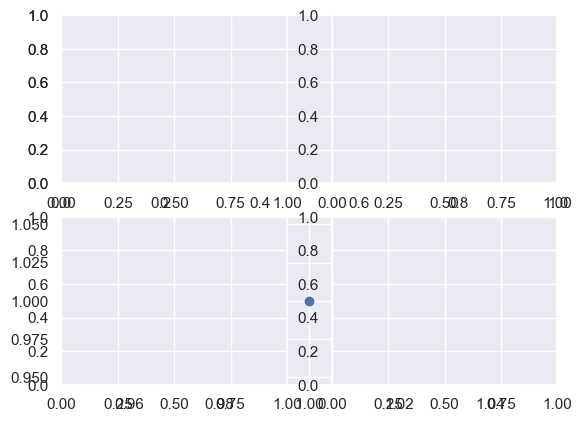

In [ ]:
fig, axes = plt.subplots(2, 1)
subfig, subaxes = fig.subplots(2, 2)
axes[1].scatter([1], [1])